In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - JAX OWL-ViT v2

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_owl_vit_v2.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_jax_owl_vit_v2.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>                                                                                               <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_jax_owl_vit_v2.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10

## Overview

This notebook demonstrates serving a [JAX OWL-ViT v2 model](https://github.com/google-research/scenic/tree/main/scenic/projects/owl_vit) for [Simple Open-Vocabulary Object Detection with Vision Transformers](https://arxiv.org/abs/2205.06230) task and deploying them on Vertex AI for online prediction.

### Objective

In this tutorial, you learn how to:

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for open-vocabulary image object detection.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Model Registry
- Vertex AI Online Prediction

### Dataset

This notebook uses the following prediction image as an example:

Image: https://upload.wikimedia.org/wikipedia/commons/c/cd/Still_Life-_Fruit_MET_APS628.jpg

This file is made available under the Creative Commons [CC0 1.0 Universal Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/deed.en).

You can use your own custom prediction image as well as by modifying the `DEMO_IMAGE_PATH` variable in this notebook below.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
# Install the packages.
! pip install --upgrade google-cloud-aiplatform
! pip install tensorflow==2.12.0
! pip install numpy==1.23.5
! pip install Pillow==9.1.1
! pip install matplotlib==3.8.0

### Colab only

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages.
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).


### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = ""  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Import libraries

In [ ]:
import base64
import os
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
from PIL import Image

# Display Matplotlib plots inline in the notebook.
%matplotlib inline

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [ ]:
staging_bucket = os.path.join(BUCKET_URI, "jax_owl_vit_v2_staging")
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=staging_bucket)

### Define constants

In [ ]:
# Size of the base ViT model. Either "b16" or "l14".
BASE_MODEL_SIZE = "l14"
# Training recipe used. "ST" for self-training only, "ST+FT" for self-training and fine-tuned on human annotations,
# and "ST/FT_ens" for weight-space ensemble of the two.
VARIANT = "ST/FT_ens"
# GCS locations of the pretrained SavedModels where the keys are f"{BASE_MODEL_SIZE}_{VARIANT}".
CHECKPOINT_BASE_URI = "gs://scenic-bucket/owl_vit/checkpoints"
GCS_SAVEDMODEL_LOCATIONS = {
    "b16_ST": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams_tf_model",
    "b16_ST+FT": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams-ft-lvisbase_tf_model",
    "b16_ST/FT_ens": f"{CHECKPOINT_BASE_URI}/owl2-b16-960-st-ngrams-curated-ft-lvisbase-ens-cold-weight-05_tf_model",
    "l14_FT": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams_tf_model",
    "l14_ST+FT": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams-ft-lvisbase_tf_model",
    "l14_ST/FT_ens": f"{CHECKPOINT_BASE_URI}/owl2-l14-1008-st-ngrams-ft-lvisbase-ens-cold-weight-04_tf_model",
}

GCS_CONVERTED_SAVED_MODEL_DIR = f"{BUCKET_URI}/owl2_saved_model"
# The pre-built prediction docker image.
OPTIMIZED_TF_RUNTIME_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai-restricted/prediction/tf_opt-cpu.nightly:latest"
)

### Define common functions

This section defines functions for:

- Converting input text queries into the required prediction input format.
- Createing a serving function for the modified SavedModel which takes jpeg bytes and text queries bytes as an input.
- Getting JPEG bytes given an image path and resizes if required.
- Getting text queries list as bytes.
- Plotting the predicted bounding boxes and labels on the given image.

In [ ]:
def parse_text_queries(tensor_byte_string):
    """Converts text query bytes to string tensor as an input for the original SavedModel."""
    return tf.io.parse_tensor(tensor_byte_string, tf.string)


def get_serve_fn(model):
    """Creates a serving function for the modified SavedModel which takes jpeg bytes and text-embeddings bytes as an input."""

    @tf.function(
        input_signature=[
            tf.TensorSpec([None], tf.string),
            tf.TensorSpec([None], tf.string),
        ]
    )
    def serve_fn(image_jpeg_bytes_inputs, text_queries_bytes_inputs):
        text_queries = tf.map_fn(
            parse_text_queries,
            text_queries_bytes_inputs,
            dtype=tf.string,
        )
        model_output = model(image=image_jpeg_bytes_inputs, text_queries=text_queries)
        return {
            "predicted_boxes": model_output["predicted_boxes"],
            "instance_logits_image": model_output["instance_logits_image"],
        }

    return serve_fn


def get_jpeg_bytes(image_path, new_width=-1):
    """Returns jpeg bytes given an image path and resizes if required."""
    with tf.io.gfile.GFile(image_path, "rb") as f:
        image = Image.open(f)
    if new_width <= 0:
        new_image = image
    else:
        width, height = image.size
        print("original input image size: ", width, " , ", height)
        new_height = int(height * new_width / width)
        print("new input image size: ", new_width, " , ", new_height)
        new_image = image.resize((new_width, new_height))
    buffered = BytesIO()
    new_image.save(buffered, format="JPEG")
    return buffered.getvalue()


def get_text_queries_bytes(text_queries):
    """Returns text queries list as bytes."""
    tensor_array = tf.convert_to_tensor(text_queries)
    tensor_byte_string = tf.io.serialize_tensor(tensor_array)
    return tensor_byte_string.numpy()


def plot_predictions(
    image, logits, boxes, text_queries, score_threshold=0.1, max_num_boxes=200
):
    """Plots the predicted bounding boxes and labels on the given image."""
    colors = plt.cm.hsv(np.linspace(0.0, 1.0, len(text_queries)))
    logits = logits[..., : len(text_queries)]  # Remove padding.
    scores = tf.nn.sigmoid(np.max(logits, axis=-1)).numpy()
    labels = np.argmax(logits, axis=-1)

    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.imshow(image, extent=(0, 1, 1, 0))
    ax.set_aspect(image.shape[0] / image.shape[1])
    ax.set_axis_off()

    num_boxes = 0
    for score, box, label in zip(scores, boxes, labels):
        color = colors[label % 10]
        if score < score_threshold:
            continue
        if num_boxes >= max_num_boxes:
            break
        num_boxes += 1

        y0, x0, y1, x1 = box
        cx, cy, w, h = (x0 + x1) / 2, (y0 + y1) / 2, x1 - x0, y1 - y0
        ax.plot(
            [cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
            [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2],
            color=color,
            zorder=10 + score,
        )
        ax.text(
            cx - w / 2,
            cy + h / 2 + 0.015,
            f"{text_queries[label]}: {score:1.2f}",
            ha="left",
            va="top",
            color=color,
            zorder=10 + score,
            bbox={
                "facecolor": "white",
                "edgecolor": color,
                "boxstyle": "square,pad=.3",
            },
        )

## Convert OWL-ViT v2 SavedModel to support smaller input size

The OWL-ViT v2 SavedModel takes images and text queries as input. But you can not send these inputs directly for Vertex AI Online Prediction because there is a limit of 1.5 MB on the prediction request size. So you will first convert the SavedModel format to take jpeg bytes and text queries bytes as an input instead. This modified input format will meet the 1.5 MB limit requirement.

In [ ]:
model = tf.saved_model.load(GCS_SAVEDMODEL_LOCATIONS[f"{BASE_MODEL_SIZE}_{VARIANT}"])
signatures = {
    "serving_default": get_serve_fn(model=model).get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string),
        tf.TensorSpec(shape=[None], dtype=tf.string),
    )
}

tf.saved_model.save(model, GCS_CONVERTED_SAVED_MODEL_DIR, signatures=signatures)

In [ ]:
! gsutil ls {GCS_CONVERTED_SAVED_MODEL_DIR}

In [ ]:
jax_owl2_model = aiplatform.Model.upload(
    display_name="jax_owl2",
    artifact_uri=GCS_CONVERTED_SAVED_MODEL_DIR,
    serving_container_image_uri=OPTIMIZED_TF_RUNTIME_IMAGE_URI,
    serving_container_args=[],
    location=REGION,
)

jax_owl2_endpoint = jax_owl2_model.deploy(
    deployed_model_display_name="jax_owl2_deployed",
    traffic_split={"0": 100},
    machine_type="n1-highmem-16",
    min_replica_count=1,
    max_replica_count=1,
)

Define your own categories in the cell below.

In [ ]:
# Local path to the prediction image.
DEMO_IMAGE_PATH = "./prediction_image.jpg"
# Download the prediction image.
! wget -O {DEMO_IMAGE_PATH} https://upload.wikimedia.org/wikipedia/commons/c/cd/Still_Life-_Fruit_MET_APS628.jpg

In [ ]:
TEXT_QUERIES = ["peach", "glass", "melon", "bottle", "egg", "grape"]

In [ ]:
image_bytes = get_jpeg_bytes(DEMO_IMAGE_PATH)
text_queries_bytes_inputs = get_text_queries_bytes(TEXT_QUERIES)

instances_list = [
    {
        "image_jpeg_bytes_inputs": {
            "b64": base64.b64encode(image_bytes).decode("utf-8")
        },
        "text_queries_bytes_inputs": {
            "b64": base64.b64encode(text_queries_bytes_inputs).decode("utf-8")
        },
    }
]
instances = [json_format.ParseDict(s, Value()) for s in instances_list]
predictions = jax_owl2_endpoint.predict(instances=instances).predictions[0]

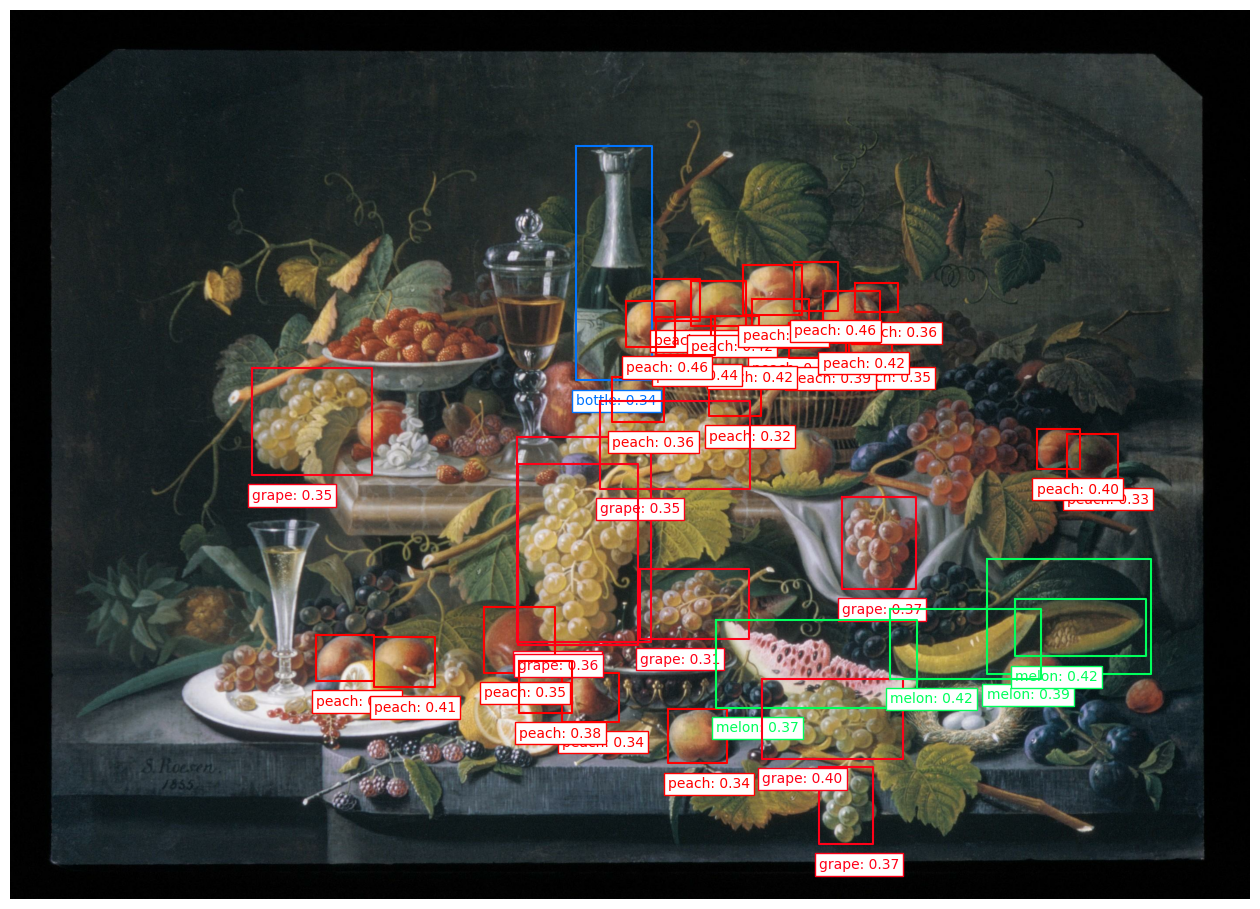

In [30]:
plot_predictions(
    image=tf.image.decode_image(image_bytes).numpy(),
    logits=np.asarray(predictions["instance_logits_image"]),
    boxes=np.asarray(predictions["predicted_boxes"]),
    text_queries=TEXT_QUERIES,
    score_threshold=0.3,
)

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Delete endpoint resource.
jax_owl2_endpoint.delete(force=True)

# Delete model resource.
jax_owl2_model.delete()

# Delete Cloud Storage objects that were created by setting `delete_bucket = True`.
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI